# Build a brain model for decilitated cell

In [1]:
from brian2tools import *
from brian2 import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
from brian2.units.constants import faraday_constant as F
from brian2.units.constants import gas_constant as R
from brian2.units.constants import zero_celsius as temp

In [3]:
import numpy as np
import pandas as pd

In [4]:
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!


In [5]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [6]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [7]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [8]:
np.shape(Vout)

(20, 22399)

In [9]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

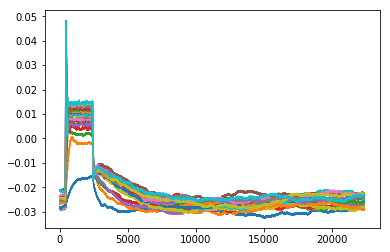

In [10]:
plot(Vout.transpose());

#### Get positive injection current

In [11]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

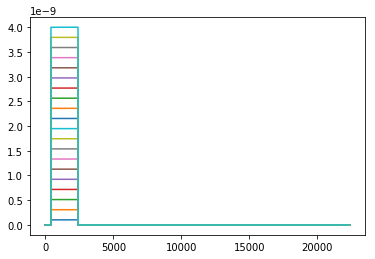

In [12]:
plot(Ic.transpose());

#### Get white noise injection

In [13]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

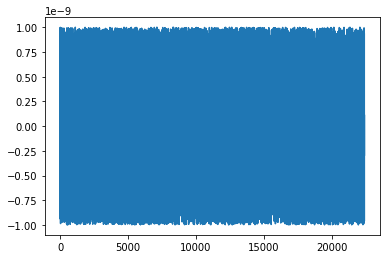

In [14]:
plot(Inoise);

#### Get V from white noise

In [15]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

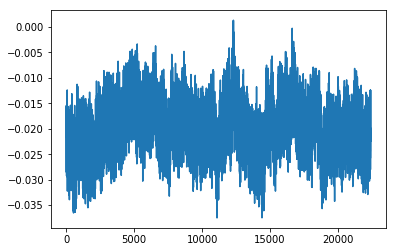

In [16]:
plot(Vnoise);

### Concatinate the data

In [17]:
np.shape(Vnoise)

(22400,)

In [18]:
np.shape(Vout)

(20, 22399)

In [19]:
output = np.concatenate((Vout[:,:10000], [Vnoise[:10000]]))
np.shape(output)

(21, 10000)

In [20]:
input_cur = np.concatenate((Ic[:, :10000], [Inoise[:10000]]))
np.shape(input_cur)

(21, 10000)

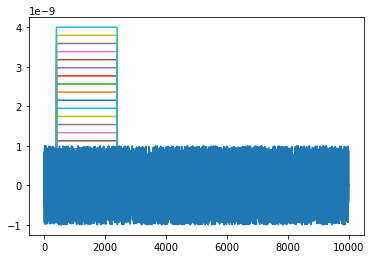

In [21]:
plot(input_cur.transpose());

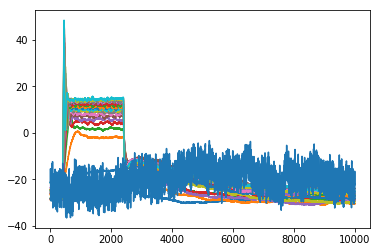

In [22]:
plot((output/1e-3).transpose());

## Build a model

In [23]:
# T = 200*kelvin
# F = F
# R = R              

# Ek=-48.8 * mV
# v=-30*mV

# ((1-exp(((Ek-v)*F)/(R*T)))/(1-exp((-v*F)/(R*T))))

In [24]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [25]:
# (abs(v)+0.0001*mV)*sign(v)

In [33]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)* v * ((1-exp(((Ek-v)*F)/(R*T)))/(1-exp((-v*F)/(R*T)))) + I(t))/C + 0.00001*metre**2*kilogram*second**-4*amp**-1: volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              
)

In [34]:
start_scope()

G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'v': -30*mV})
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1, 'EL':1, 'gL':1, 'C':1}, units=False)

In [35]:
run(10*ms)

In [66]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)* v * ((1-exp(((Ek-v)*F)/(R*T)))/(1-exp(((-v+0.0001*mV)*F)/(R*T)))) + I(t))/C : volt

dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v+0.0001*mV)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v+0.0001*mV-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              
)

In [67]:
model

dv/dt = (gL*(EL - v) + g_k*n**4.0*v*(1.0 - exp(39.5856119633881*amp*second*(Ek - v)/joule))/(1.0 - exp(39.5856119633881*amp*second*(0.0001*mV - v)/joule)) + I(t))/C : volt
dn/dt = alpha*(1.0 - n) - beta*n : radian
alpha = 0.5*(-Vn + v)/(kn*taun*(1.0 - exp((Vn + 0.0001*mV - v)/kn))) : hertz
beta = -0.5*(-Vn + v)/(kn*taun*(1.0 - exp((-Vn + 0.0001*mV + v)/kn))) : hertz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn : volt (constant)
Ek : volt (constant)
C : farad (constant)
EL : volt (constant)
gL : siemens (constant)


In [68]:
start_scope()

G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'v': -30*mV})
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1, 'EL':1, 'gL':1, 'C':1}, units=False)

In [69]:
G.get_states()

{'N': array(1),
 'i': array([0], dtype=int32),
 't': 21.3 * msecond,
 'dt': 50. * usecond,
 't_in_timesteps': array(426),
 'v': array([-30.]) * mvolt,
 'n': array([0.]),
 'g_k': array([1.]) * siemens,
 'kn': array([1.]) * volt,
 'taun': array([1.]) * second,
 'Vn': array([1.]) * volt,
 'Ek': array([1.]) * volt,
 'C': array([1.]) * farad,
 'EL': array([1.]) * volt,
 'gL': array([1.]) * siemens}

In [70]:
run(10*ms)

In [71]:
G.get_states()

{'N': array(1),
 'i': array([0], dtype=int32),
 't': 10. * msecond,
 'dt': 50. * usecond,
 't_in_timesteps': array(200),
 'v': array([-7.04295589]) * kvolt,
 'n': array([2.57176764e-15]),
 'g_k': array([1.]) * siemens,
 'kn': array([1.]) * volt,
 'taun': array([1.]) * second,
 'Vn': array([1.]) * volt,
 'Ek': array([1.]) * volt,
 'C': array([1.]) * farad,
 'EL': array([1.]) * volt,
 'gL': array([1.]) * siemens}

In [117]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)* v * ((1-exp(((Ek-v)*F)/(R*T)))/(1-exp(((-v+0.0001*mV)*F)/(R*T)))) + I)/C: volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-(v+0.0001*mV))/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp(((v+0.0001*mV)-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              
)

In [118]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()


In [119]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [120]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur * amp, output=output * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-1*uS, 1e2*uS],
                        taun=[1*ms, 40*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=15, n_samples=30, optimizer=n_opt, metric=None)

index 0 errors minimum: nan
index 1 errors minimum: nan
index 2 errors minimum: nan
index 3 errors minimum: nan
index 4 errors minimum: nan
index 5 errors minimum: nan
index 6 errors minimum: nan
index 7 errors minimum: nan
index 8 errors minimum: nan
index 9 errors minimum: nan
index 10 errors minimum: nan
index 11 errors minimum: nan
index 12 errors minimum: nan
index 13 errors minimum: nan
index 14 errors minimum: nan


In [123]:
res

{'EL': -0.02365354711103486,
 'taun': 0.00975332586133774,
 'Ek': -0.03108577668226532,
 'gL': 1.4896602255806726e-08,
 'kn': 0.016632225384290437,
 'g_k': 1.6283563947706194e-05,
 'Vn': -0.014418692367183732,
 'C': 2.1447736599235066e-10}

In [122]:
Vn = 0.010574926643381185 * volt
kn = 0.013325241663945017 * volt
v = 1000*mV

In [114]:
exp((Vn-(v+0.0001*mV))/kn)

5.659629325890804e-33

In [115]:
exp((Vn-(v+0.0001*mV))/kn)

5.659629325890804e-33

In [116]:
(Vn-(v+0.0001*mV))

-0.98942517 * volt

In [130]:
res = {'g_k': 5.714285954458083e-06,
 'taun': 0.0024875309538889383,
 'kn': 0.01866848352110208,
 'Ek': -0.002957455346546213,
 'C': 1.3943779163401818e-10,
 'gL': 7.2099111440882365e-09,
 'Vn': 0.01784506737513665,
 'EL': -0.02639762114682628}



In [131]:

# visualization of the results
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur * amp, input_var='I', output_var='v',
                     param_init={'v': -30 * mV},
                     dt=dt)

fits/mV

array([[-30.        , -29.99069862, -29.98142125, ..., -27.21481832,
        -27.21481832, -27.21481832],
       [-30.        , -29.99069862, -29.98142125, ...,          nan,
                 nan,          nan],
       [-30.        , -29.99069862, -29.98142125, ...,          nan,
                 nan,          nan],
       ...,
       [-30.        , -29.99069862, -29.98142125, ...,          nan,
                 nan,          nan],
       [-30.        , -29.99069862, -29.98142125, ...,          nan,
                 nan,          nan],
       [-30.        , -29.69027566, -29.49415563, ..., -27.96064838,
        -28.09461627, -27.77935302]])

In [132]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());


WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/matplotlib/transforms.py:2902: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/matplotlib/transforms.py:429: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel di

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd96985d1e0> (for post_execute):


IndexError: index 0 is out of bounds for axis 0 with size 0

IndexError: index 0 is out of bounds for axis 0 with size 0

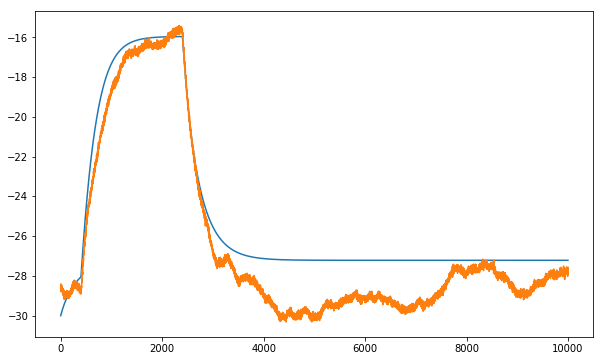

In [133]:
d = 0
plt.figure(figsize=(10,6))
plot(fits[d]/mV)
plot(output[d]/1e-3);